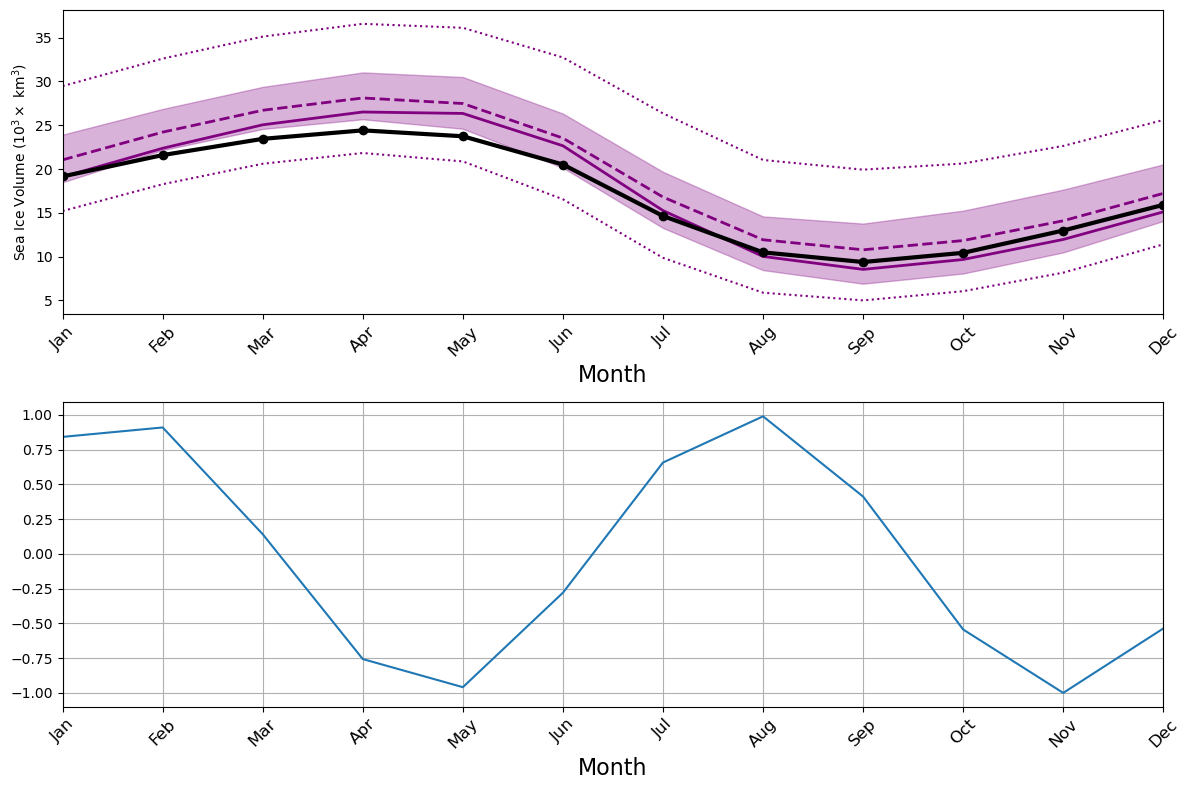

In [19]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# Open the dataset.
ds = xr.open_dataset("../cmip6_sea_ice_variability/data/piomas_ice_thickness.nc")

# Extract effective ice thickness (in meters) and mask unrealistic values.
heff = ds['heff'].where((ds['heff'] > 1e-8) & (ds['heff'] < 50))

# Define the grid cell area (in m²); for a 25 km x 25 km cell.
grid_cell_area = 25e3 * 25e3  # equals 6.25e8 m²

# Compute the cell volume by multiplying thickness by grid cell area.
cell_volume = heff * grid_cell_area

# Integrate over the spatial dimensions "xc" and "yc"
integrated_volume = cell_volume.sum(dim=['xc', 'yc']).squeeze()

# Convert the integrated volume from m³ to km³ by dividing by 1e9.
integrated_volume_km3 = integrated_volume / 1e12

obs_clim = integrated_volume_km3.groupby('time.month').mean(dim='time')
obs_vals = obs_clim.values  # length‐12

# print("Integrated Sea Ice Volume (km³):")
# print(integrated_volume_km3)


csv_dir = "sivol_data/"
csv_files = glob.glob(os.path.join(csv_dir, "*.sivol.csv"))

all_ensemble_means = []

for csv_file in csv_files:
    sivol_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    sivol_df.index = pd.to_datetime(sivol_df.index)
    
    # group by calendar month, then mean over time for each ensemble member
    monthly_by_ens = sivol_df.groupby(sivol_df.index.month).mean()  # shape (12, E)
    # mean across ensemble members -> 12‐element array of m³
    monthly_mean = monthly_by_ens.mean(axis=1).to_numpy()          # shape (12,)
    
    all_ensemble_means.append(monthly_mean)

ensemble_means_array = np.vstack(all_ensemble_means)  # shape (M,12)

ensemble_means_array_km3 = ensemble_means_array / 1e12

ensemble_mean     = np.mean(ensemble_means_array_km3, axis=0) 
ensemble_median   = np.median(ensemble_means_array_km3, axis=0) 
pct5              = np.percentile(ensemble_means_array_km3,   5, axis=0)
pct25             = np.percentile(ensemble_means_array_km3,  25, axis=0)
pct75             = np.percentile(ensemble_means_array_km3,  75, axis=0)
pct95             = np.percentile(ensemble_means_array_km3,  95, axis=0)

# 4) Plot
month_values = np.arange(1, 13)
month_labels = ['Jan','Feb','Mar','Apr','May','Jun',
                'Jul','Aug','Sep','Oct','Nov','Dec']

# plt.figure(figsize=(12, 8))
fig, axs = plt.subplots(figsize=(12, 8), nrows=2)

ax = axs[0]
# shaded 25th and 75th percentile
ax.fill_between(month_values, pct25, pct75, color='purple', alpha=0.3, label='25th-75th Percentile Range')

# mean & median
ax.plot(month_values, ensemble_mean, color='purple', linestyle='--', linewidth=2, label='Ensemble Mean')
ax.plot(month_values, ensemble_median, color='purple', linestyle='-', linewidth=2, label='Ensemble Median')

# 5th and 95th percentiles
ax.plot(month_values, pct5, color='purple', linestyle=':', linewidth=1.5, label='5th Percentile')
ax.plot(month_values, pct95, color='purple', linestyle=':', linewidth=1.5, label='95th Percentile')

ax.plot(month_values, obs_vals, 'k-o', linewidth=3, label='Observations')
ax.set_ylabel('Sea Ice Volume (10$^3 \\times $ km$^3$)')


ax = axs[1]
# put another variable here with its own ylim
ax.plot(month_values, np.sin(month_values))


for ax in axs:
    ax.set_xticks(month_values)
    ax.set_xticklabels(month_labels, rotation=45, size=12)
    ax.set_xlabel('Month', size=16)    
    ax.set_xlim(1, 12)

# plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
ax.set_xticks?

Signature: ax.set_xticks(ticks, *, minor=False)
Docstring:
Set the xaxis' tick locations.

If necessary, the view limits of the Axis are expanded so that all
given ticks are visible.

Parameters
----------
ticks : list of floats
    List of tick locations.
minor : bool, default: False
    If ``False``, set the major ticks; if ``True``, the minor ticks.

Notes
-----
The mandatory expansion of the view limits is an intentional design
choice to prevent the surprise of a non-visible tick. If you need
other limits, you should set the limits explicitly after setting the
ticks.
File:      /opt/miniconda3/envs/cmip6/lib/python3.9/site-packages/matplotlib/axes/_base.py
Type:      method